In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetB3
from keras import layers

Utils

In [2]:
import matplotlib.pyplot as plt
def plot_graph(h, accType, name):
    plt.plot(h.history[accType])
    plt.plot(h.history["val_" + accType])
    plt.title("model accuracy")
    plt.ylabel(accType)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    fig = plt.gcf()
    name = "graphs/" + name + ".png"
    fig.savefig(name)
    plt.show()

Dataset

In [3]:
import dataset
dataset = dataset.Dataset()

In [4]:
DATAPATH = 'data/'
IMG_SIZE = 224 
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 32
LABELS = dataset.getLabelList()
# change labels = LABELS for regression
(train_set, test_set) = tf.keras.utils.image_dataset_from_directory(
    DATAPATH,
    image_size = SIZE,
    batch_size = BATCH_SIZE,
    labels = "inferred",
    label_mode = 'int',
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'both',
    seed = 1234,
)

['-348', '22', '-400', '1', '550', '-1948', '-1948', '-1948', '-1344', '-2419', '5', '-2175', '-1450', '50', '-2577', '-1323', '-1370', '23', '-250', '-196', '-2553', '-1777', '22', '-1344', '-1342', '-1880', '-2419', '-1344', '-2450', '-1400', '-977', '7', '8', '-1344', '-81', '-2950', '-2985', '1937', '1937', '-57', '-57', '1', '-349', '-57', '1323', '-594', '-1240', '1', '1306', '550', '80', '1238', '145', '2', '-1452', '9', '-2568', '-5000', '-2667', '-594', '-350', '-2553', '-2050', '10', '-932', '130', '-3100', '38', '-3100', '-680', '-1024', '-1129', '-2649', '-425', '-886', '-996', '1372', '-1024', '-1291', '1509', '1371', '1452', '1452', '1344', '832', '-2330', '-2307', '-2291', '-2330', '1', '-2300', '3', '-1416', '307', '250', '550', '-750', '-2330', '-1275', '1857', '677', '1332', '-908', '1468', '168', '829', '350', '-200', '1350', '50', '300', '1897', '550', '1849', '1332', '1717', '266', '603', '1723', '660', '1327', '168', '57', '1243', '1850', '1413', '643', '1939', '3

In [ ]:
Krizhevsky_Datapath = 'data/'
Krizhevsky_Size = (224, 224)

(krizhevsky_train_set, krizhevsky_test_set) = tf.keras.utils.image_dataset_from_directory(
    Krizhevsky_Datapath,
    image_size = Krizhevsky_Size,
    batch_size = 128,
    labels = "inferred",
    label_mode = 'int',
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'both',
    seed = 1234,
)

In [6]:
print(train_set.class_names)
num_classes = len(train_set.class_names)
num_classes

['-1', '-10', '-11', '-12', '-13', '-14', '-15', '-16', '-17', '-18', '-19', '-2', '-20', '-22', '-23', '-24', '-25', '-26', '-27', '-28', '-29', '-3', '-30', '-31', '-32', '-34', '-35', '-38', '-4', '-5', '-50', '-6', '-7', '-8', '-9', '-90', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


56

EfficientNetB3 with Sparse Categorical Crossentropy

In [6]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=augmented, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    outputs = layers.Dense(num_classes, activation="softmax")(dropout)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


EfficientNetB3 with Sparse Categorical Crossentropy with dense layers

In [7]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=augmented, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    layer3 = layers.Dense(units = 512, activation='relu')(dropout)
    layer2 = layers.Dense(units = 256, activation='relu')(layer3)
    layer1 = layers.Dense(units = 128, activation='relu')(layer2)
    outputs = layers.Dense(num_classes, activation="softmax")(layer1)
    modelEfficientNetConnected = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNetConnected.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


EfficientNetB3 with Sparse Categorical Crossentropy with dense layers and dropout

In [8]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=augmented, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout3 = layers.Dropout(0.2)(batch_norm)
    layer3 = layers.Dense(units = 512, activation='relu')(dropout3)
    dropout2 = layers.Dropout(0.2)(layer3)
    layer2 = layers.Dense(units = 256, activation='relu')(layer3)
    dropout1 = layers.Dropout(0.2)(layer2)
    layer1 = layers.Dense(units = 128, activation='relu')(layer2)
    outputs = layers.Dense(num_classes, activation="softmax")(layer1)
    modelEfficientNetConnectedDropout = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNetConnectedDropout.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


EfficientNet3 with Mean Absolute Error

In [6]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    outputs = layers.Dense(units = 1)(dropout)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=["mean_absolute_error"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


EfficientNetB3 with MAE, larger fully connected layer

In [10]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    layer3 = layers.Dense(units = 512, activation='relu')(dropout)
    layer2 = layers.Dense(units = 256, activation='relu')(layer3)
    layer1 = layers.Dense(units = 64, activation='relu')(layer2)
    outputs = layers.Dense(units = 1)(layer1)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=["mean_absolute_error"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model from [this](https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow) StackOverflow post. <br>
This uses a regression model.

In [7]:
augmentation_layer = tf.keras.Sequential([                                    
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
], name='data_augmentation')  

model = tf.keras.Sequential([
    augmentation_layer,
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss='mean_absolute_error', optimizer="adam", metrics=['mean_absolute_error'])

Network from [This](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) paper _without_ multi GPU: <br>
5 Conv layers followed by 3 fully connected layers. Afer each fully connected layer, a ReLu unit is used as nonlinearity. Additionally normalization and dropout are applied 
(found via [Image Orientation Estimation with Convolutional Networks](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf)). <br>
**Not Implemented**: 
- Multiple GPUs
- First Layers with Stride of 4

Other hyper parameters to change: 
- Batch size of 128
- 90 cycles through the training set

In [30]:
callbacks = [ tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)] # Paper does not specify the patience, so I chose 5
optimizer = tf.keras.optimizers.experimental.SGD(weight_decay=0.0005, learning_rate=0.01, momentum=0.9)

one_bias_initializer = tf.keras.initializers.Constant(value=1)
zero_bias_initializer = tf.keras.initializers.Constant(value=0)

KrizhevskyModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(5, 5, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
])

KrizhevskyModel.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
EPOCHS = 100

EfficientNet

In [ ]:
histEfficientNet = modelEfficientNet.fit(train_set, epochs=EPOCHS, validation_data=test_set) 

In [ ]:
plot_graph(histEfficientNet, "accuracy", "EfficientNetB3")

In [10]:
histEfficientNetConnected = modelEfficientNetConnected.fit(train_set, epochs=EPOCHS, validation_data=test_set)

Epoch 1/100
317/317 [==============================] - 1559s 5s/step - loss: 1.6023 - accuracy: 0.5595 - val_loss: 1.7020 - val_accuracy: 0.5124
Epoch 2/100
317/317 [==============================] - 1526s 5s/step - loss: 1.3500 - accuracy: 0.6073 - val_loss: 1.3774 - val_accuracy: 0.5988
Epoch 3/100
317/317 [==============================] - 1523s 5s/step - loss: 1.2423 - accuracy: 0.6301 - val_loss: 1.3547 - val_accuracy: 0.6004
Epoch 4/100
317/317 [==============================] - 1523s 5s/step - loss: 1.1638 - accuracy: 0.6521 - val_loss: 1.1888 - val_accuracy: 0.6501
Epoch 5/100
317/317 [==============================] - 1523s 5s/step - loss: 1.0964 - accuracy: 0.6706 - val_loss: 1.2229 - val_accuracy: 0.6323
Epoch 6/100
317/317 [==============================] - 1527s 5s/step - loss: 1.0470 - accuracy: 0.6803 - val_loss: 1.4158 - val_accuracy: 0.6036
Epoch 7/100
317/317 [==============================] - 1529s 5s/step - loss: 0.9752 - accuracy: 0.7032 - val_loss: 1.5714 - val_ac

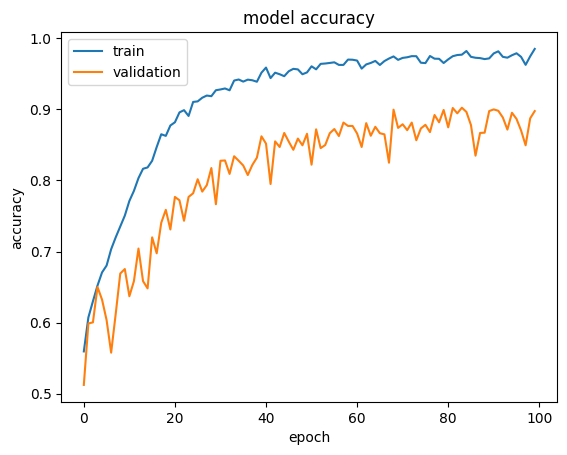

In [11]:
plot_graph(histEfficientNetConnected, "accuracy", "EfficientNetB3Connected")

In [12]:
histEfficientNetConnectedDropout = modelEfficientNetConnectedDropout.fit(train_set, epochs=EPOCHS, validation_data=test_set)

Epoch 1/100
317/317 [==============================] - 1779s 6s/step - loss: 1.5972 - accuracy: 0.5723 - val_loss: 2.0432 - val_accuracy: 0.4955
Epoch 2/100
317/317 [==============================] - 1741s 5s/step - loss: 1.4216 - accuracy: 0.5933 - val_loss: 1.6542 - val_accuracy: 0.6047
Epoch 3/100
317/317 [==============================] - 1748s 6s/step - loss: 1.2855 - accuracy: 0.6197 - val_loss: 1.4038 - val_accuracy: 0.6114
Epoch 4/100
317/317 [==============================] - 1726s 5s/step - loss: 1.2469 - accuracy: 0.6309 - val_loss: 1.2457 - val_accuracy: 0.6320
Epoch 5/100
317/317 [==============================] - 1731s 5s/step - loss: 1.1646 - accuracy: 0.6427 - val_loss: 1.2752 - val_accuracy: 0.6308
Epoch 6/100
317/317 [==============================] - 1730s 5s/step - loss: 1.0905 - accuracy: 0.6643 - val_loss: 1.5147 - val_accuracy: 0.5546
Epoch 7/100
317/317 [==============================] - 1736s 5s/step - loss: 1.0449 - accuracy: 0.6809 - val_loss: 1.2184 - val_ac

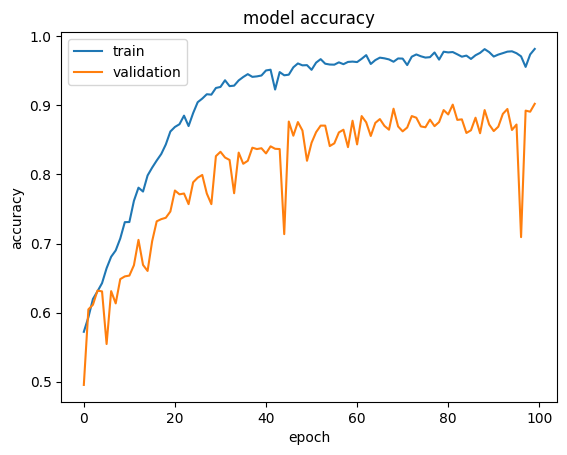

In [13]:
plot_graph(histEfficientNetConnectedDropout, "accuracy", "EfficientNetB3ConnectedDropout")

Model

In [ ]:
histModel = model.fit(train_set, epochs=EPOCHS, validation_data=test_set)

In [ ]:
plot_graph(histModel, "mean_absolute_error", "Model1")

Krizhevsky

In [ ]:
histKrizhevsky = KrizhevskyModel.fit(train_set, epochs=90, validation_data=test_set, callbacks=callbacks)

In [ ]:
plot_graph(histKrizhevsky, "accuracy", "Krizhevsky")

AutoKeras from [this](https://autokeras.com/tutorial/image_regression/) tutorial

In [ ]:
import autokeras as ak

reg = ak.ImageRegressor(overwrite=True, max_trials=5, loss="mean_absolute_error", metrics=["mean_absolute_error"])
reg.fit(train_set, epochs=10)